In [1]:
# %matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines

import pandas as pd
import numpy as np

import glob
import re
import os
import sys 
import json

import pyds9 as ds9

from scipy.ndimage import gaussian_filter

import requests
from bs4 import BeautifulSoup
import urllib.request 

from astropy.io import fits
from astropy.table import Table
import astropy.wcs as wcs
from astropy.visualization import make_lupton_rgb

import seaborn as sns

from airium import Airium

# import dominate
# from dominate.tags import *

In [2]:
def get_evt2_file(obsid, path='.'):
    '''
    We assume that there exists a single evt2 file in primary directory in CXC database
    '''
    
    # folders organized by last digit of obsid
    last = str(obsid)[-1]
    primary_url = f'https://cxc.cfa.harvard.edu/cdaftp/byobsid/{last}/{str(obsid)}/primary'
    
    _ = glob.glob(f'{path}/*{int(obsid):05d}*')
    if _: return f'{primary_url}/{os.path.basename(_[0])}', _[0]
    
    html_text = requests.get(primary_url).text
    soup = BeautifulSoup(html_text, 'html.parser')
    
    evt2_list = [_.get('href') for _ in soup.find_all('a') if re.search(r'evt2', _.get('href'))]
    if len(evt2_list) != 1:
        print(f'Error: there are {len(evt2_list)} evt2 files: {evt2_list}')
        
    evt2_filename = evt2_list[0]
                
    urllib.request.urlretrieve(f'{primary_url}/{evt2_filename}', f'{path}/{evt2_filename}')
    
    return f'{primary_url}/{evt2_filename}', f'{path}/{evt2_filename}'

In [3]:
def xy_filter_evt2(evt2_data, ccd_split=False):
    
    X = evt2_data
    
    cols = ['ccd_id', 'x', 'y', 'energy']
    
    mask = (500 < X['energy']) & (X['energy'] < 8000)
    
#     X = Table(X)[mask][cols].to_pandas()

    X = Table(X)[cols].to_pandas()
    
    if ccd_split:
        ccds = np.unique(X['ccd_id'].tolist())
    
        xy = {ccd: data[['x', 'y']].values.astype(None).T for ccd, data in X.groupby('ccd_id')}
    else:
        xy = X[['x', 'y']].values.astype(None).T
    
    return xy

In [6]:
def process_fits(fn):
    
    with fits.open(fn) as _:
        head = _[1].header
        evt2_data = _[1].data
    
    return evt2_data, head

In [7]:
def get_summary(fn):    
    summary = open(fn).read().splitlines()

    head = [_.strip() for _ in summary[0].split(',')]

    head[0] = head[0][2:]

    summary_dict = {}

    for s in summary[1:]:
        vals = [_.strip() for _ in s.split(',')]

        vals[2:6] = [float(_) for _ in vals[2:6]]

        info = {}

        for i in range(1, 6):
            info[head[i]] = vals[i]

        info[head[-1]] = vals[6:] 
                
#         k = re.search('J(\d+[-+]\d+)', vals[1]).group()
        k = vals[0]

        summary_dict[k] = info

    # if head != ['Name1', 'Name2', 'Gal l', 'Gal b', 'Size', 'Unc', 'ObsIDs']: print('error')
    # 'Name1', 'Name2', 'Gal l', 'Gal b', 'Size', 'Unc', 'ObsIDs'
    
    return summary_dict

In [8]:
# ds9 image.fits -regions load input_imageCoordinates.reg -regions system wcs -regions skyformat sexagesimal -regions save outout_skyCoordinates.reg -exit


def wcs_to_physical(fn, xy, rad, fmt):
    '''
    fmt:  fk5 | galactic | image
    
    rad in minutes
    '''
    
    d = ds9.DS9()

    d.set(f'fits {fn}')
                           
    if len(np.shape(xy))==1:
        xy = [xy] 
    
    reg = f'regions command "{fmt}; '      

    for x, y in xy: 
        
        reg += f"circle {x} {y} {rad}';"

#         ra, dec = [':'.join(row[_].strip().split()) for _ in ['ra', 'dec']]

    reg += '"'    
    
    d.set(reg)
    
#     print(d.get('regions system'))
#     print(d.get('regions skyformat'))
    
    d.set(f'regions system physical')
#     d.set('regions skyformat sexagesimal')
    
    reg = d.get('regions')
    
    xy = re.findall(r'\((.*?)\)', reg)
    
    xy = np.array([_.split(',') for _ in xy]).astype(float)
    
    if len(xy) == 1:
        return xy[0]
    else:
        return xy   

In [9]:
# obj = 'J1018-58'
# obsids = summary[obj]['ObsIDs']

# merged_fn = f'{obj}_merged_evt.fits'

# if merged_fn in os.listdir('evt2'): 
#     print('exists') # continue
    
# else:
#     merge_script = [
#         'mkdir -p evt2/merged', 
#         'cd evt2/merged',
#         f"download_chandra_obsid {','.join(obsids)}",
#         'punlearn merge_obs',
#         f"merge_obs {'/,'.join(obsids)}/ tmp clobber=yes",
#         f'mv tmp_merged_evt.fits ../{merged_fn}',
#         'rm tmp*' 
#     ]
    
# open('to_merge.sh', 'w').write('\n'.join(merge_script)) 

In [10]:
# root_dir = '.'

evt2_dir = 'evt2'
os.system(f'mkdir -p {evt2_dir}')

webdata_dir = 'website/webdata'
os.system(f'mkdir -p {webdata_dir}')

HESS_dir = 'HESS2'

summary = get_summary('summary_updated_2.txt')
# summary

obsids_info = {}
obj_info = {}

merge_script = []
os.system('rm -rf to_merge.sh')

for obj in summary.keys():
        
    obsids = summary[obj]['ObsIDs']
    
    if len(obsids) == 1:
        
        url, fn = get_evt2_file(obsids[0], path=evt2_dir) 
        
        obj_info[obj] = fn
    
    else:
        
        merged_fn = f'{obj}_merged_evt.fits'
        
        obj_info[obj] = evt2_dir + '/' + merged_fn

        if merged_fn not in os.listdir('evt2'):             
            
            merge_script += [
                f"download_chandra_obsid {','.join(obsids)}",
                'punlearn merge_obs',
                f"merge_obs {'/,'.join(obsids)}/ tmp clobber=yes",
                f'mv tmp_merged_evt.fits ../{merged_fn}',
                'rm tmp*' 
            ]

if len(merge_script):
    merge_script = ['mkdir -p evt2/merged', 'cd evt2/merged'] + merge_script                
    open('to_merge.sh', 'w').write('\n'.join(merge_script)) 
    print("run 'bash to_merge.sh' to get and merge obsids")

In [11]:
labels = []

for obj in list(summary.keys()):
    
#     nm = f'{HESS_dir}/{obj}*.csv'
#     print(nm)

    fn_csv = glob.glob(f'{HESS_dir}/{obj}*.csv')[0]
    dat_csv = pd.read_csv(fn_csv)
    
    labels.append(list(dat_csv['Class']))
    
n_sources_lst = [len(_) for _ in labels]    
    
len(sum(labels, []))    

204

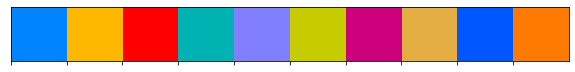

In [12]:
wolfram_colors = [[0., 0.52, 1.], [1., 0.72, 0.], [1., 0., 0.], [0., 0.7, 0.7], 
                  [0.51, 0.5, 1.], [0.784, 0.8, 0.], [0.8, 0., 0.48], 
                  [0.9, 0.6858, 0.27], [0., 0.34, 1.], [1., 0.48, 0.]]

sns.palplot(wolfram_colors)

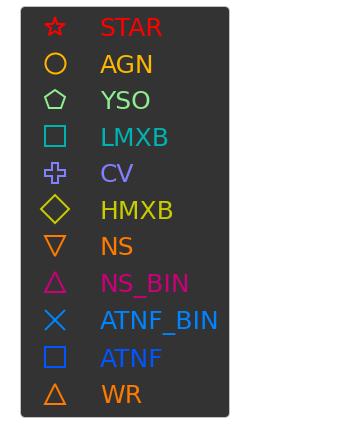

In [13]:
colors_markers = {
    'STAR': [wolfram_colors[2], '*'], 
    'AGN': [wolfram_colors[1], 'o'],         
    'YSO': ['lightgreen', 'p'], 
    'LMXB': [wolfram_colors[3], 's'],         
    'CV': [wolfram_colors[4], 'P'],         
    'HMXB': [wolfram_colors[5], 'D'], 
    'NS': [wolfram_colors[9], 'v'], 
    'NS_BIN': [wolfram_colors[6], '^'],

    'ATNF_BIN': [wolfram_colors[0], 'x'], 
    'ATNF': [wolfram_colors[8], 's'],
    'WR': [wolfram_colors[9], '^']
}

handles = [mlines.Line2D([], [], 
                         color=color, 
                         marker=marker, 
                         linestyle='None', 
                         markerfacecolor='None',
                         markeredgewidth=2, 
                         markersize=20, 
                         label=label) 
           for label, (color, marker) in colors_markers.items()]

fig, ax = plt.subplots()

legend = plt.legend(handles=handles, loc='lower left', fontsize=25, facecolor='k')

for text, v in zip(legend.get_texts(), colors_markers.values()):
    text.set_color(v[0])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

plt.show()

In [18]:
print(dat_csv['significance']+1)

0    6.48
Name: significance, dtype: float64


J1018-58


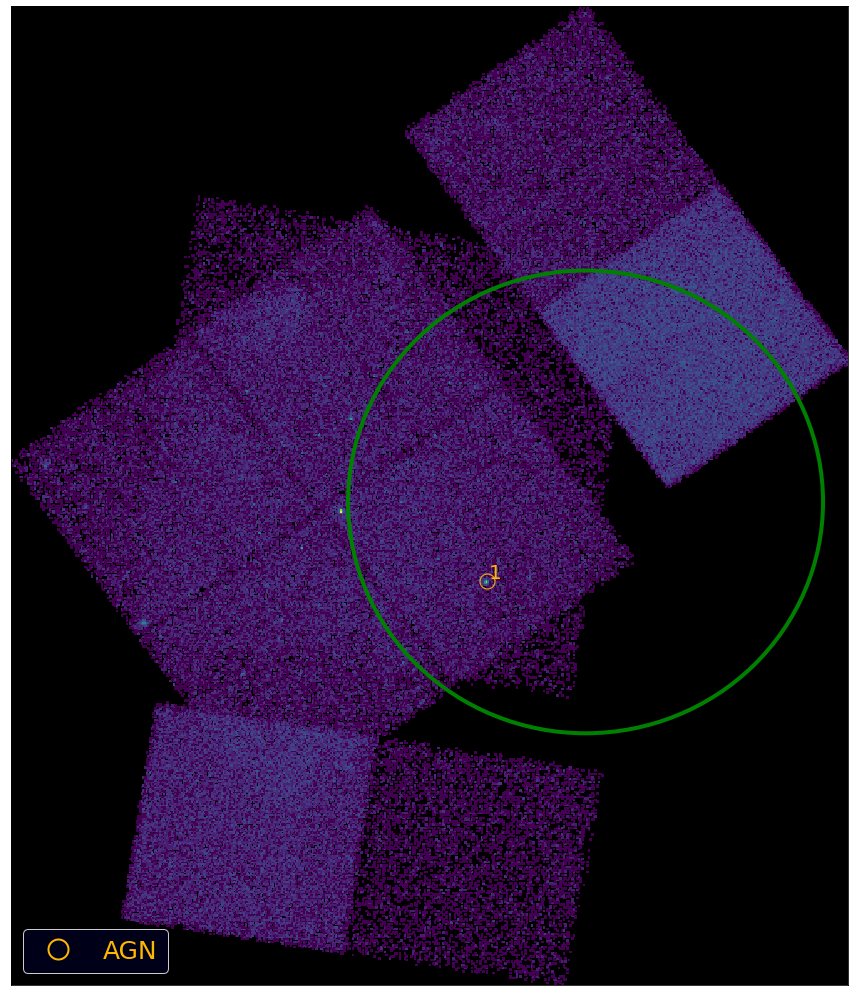

J1023-57


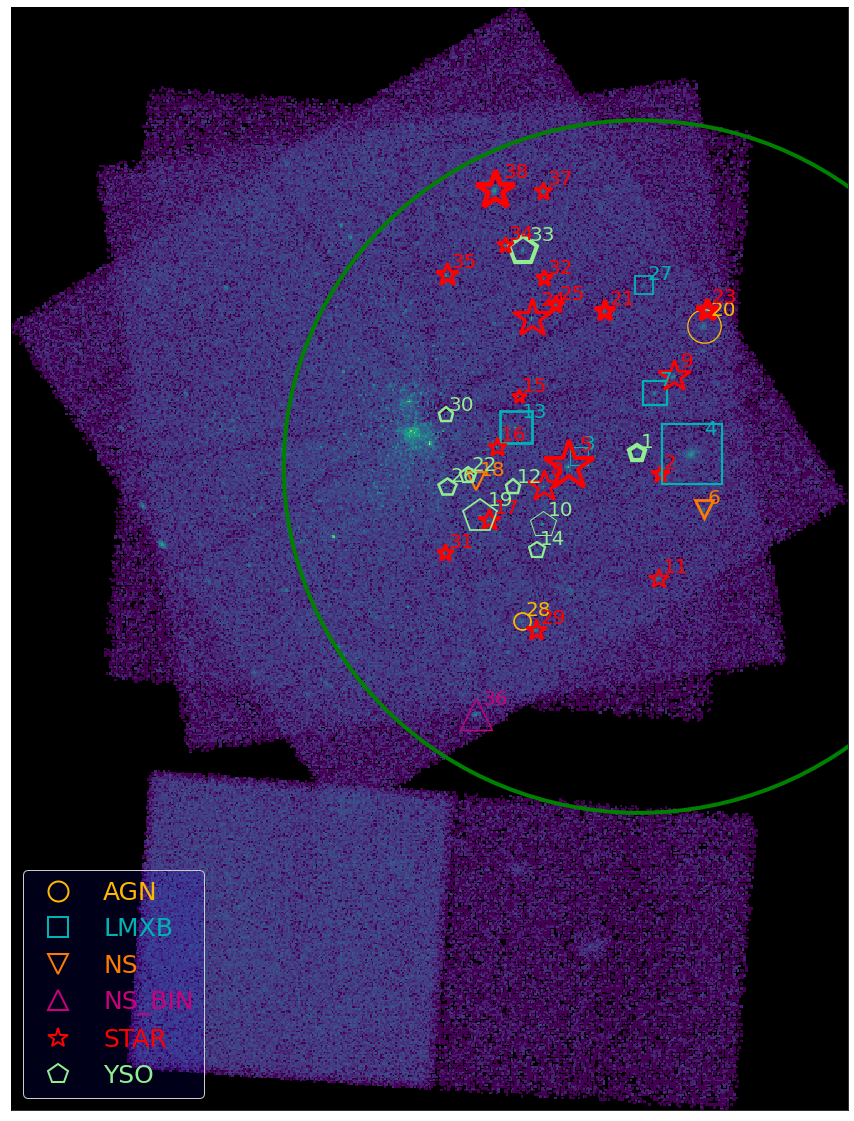

J1458-60


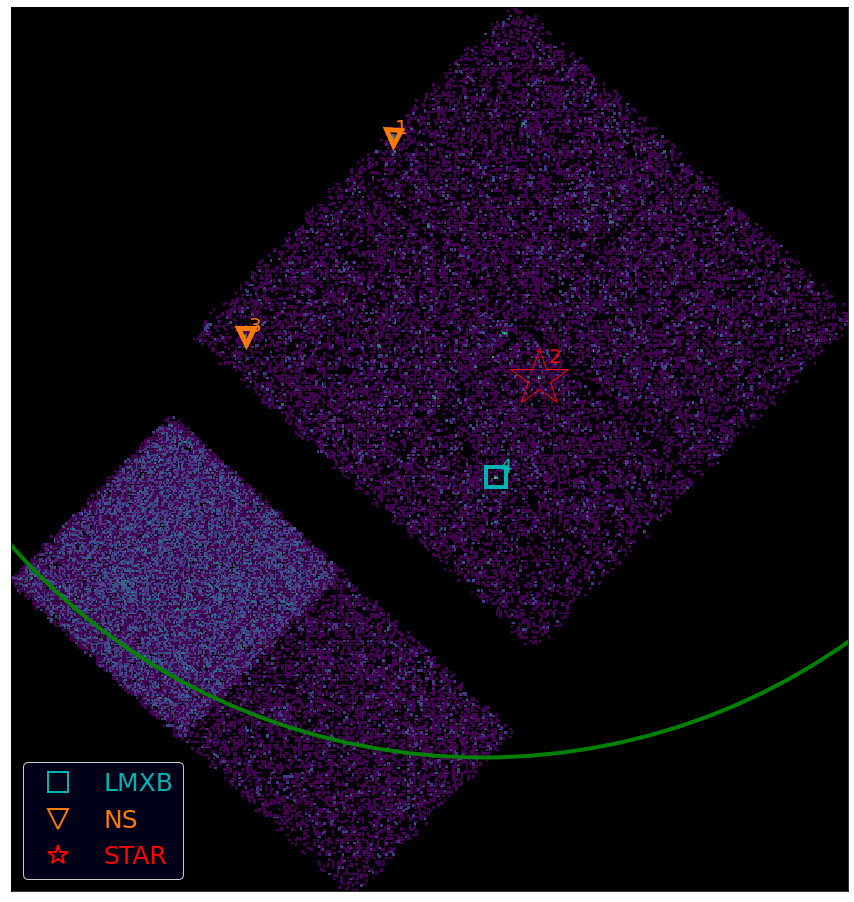

J1507-62


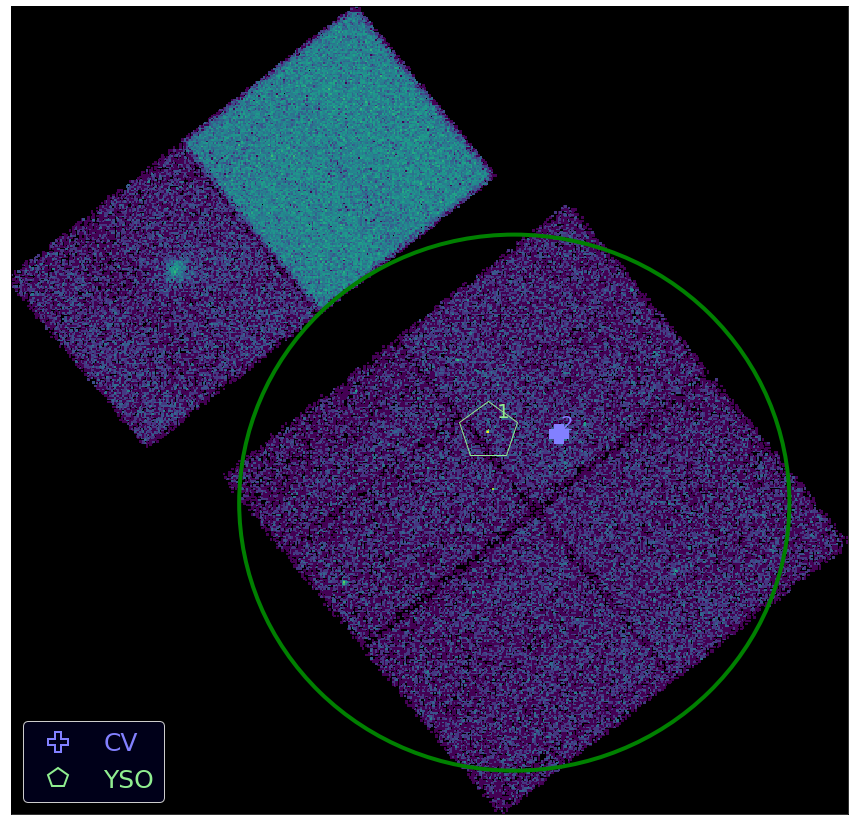

J1616-50


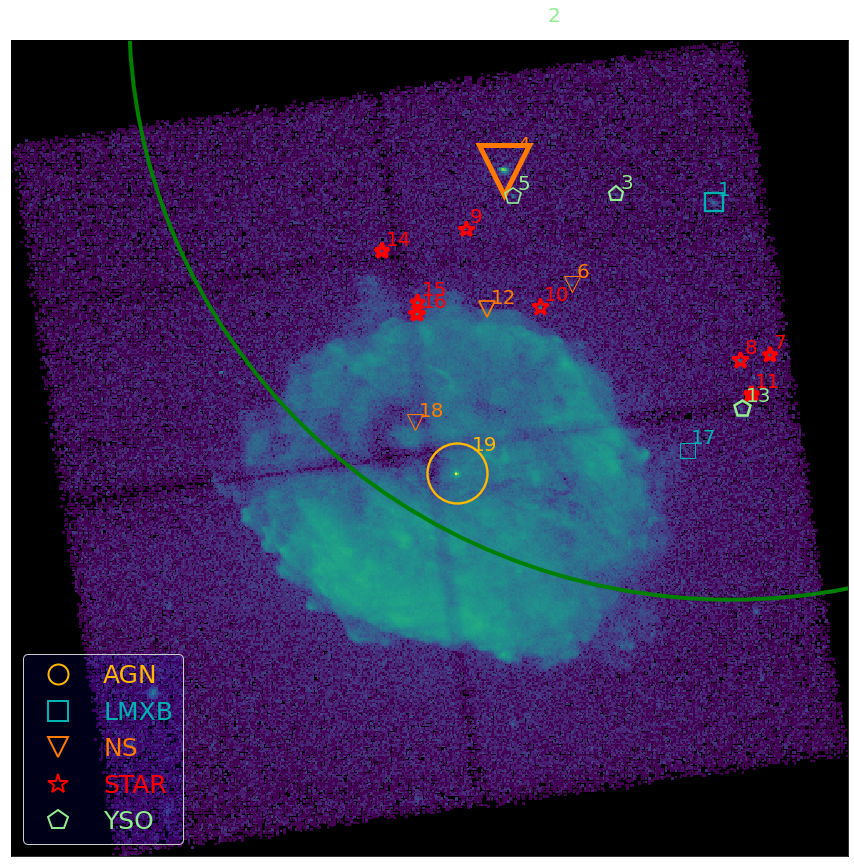

J1626-49


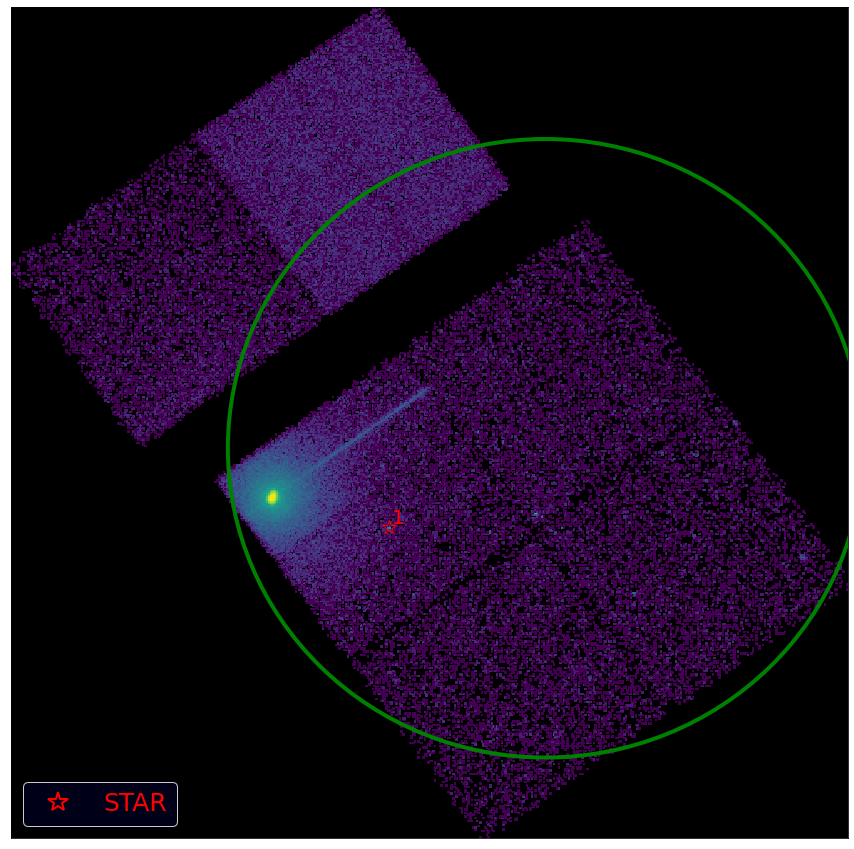

J1632-47


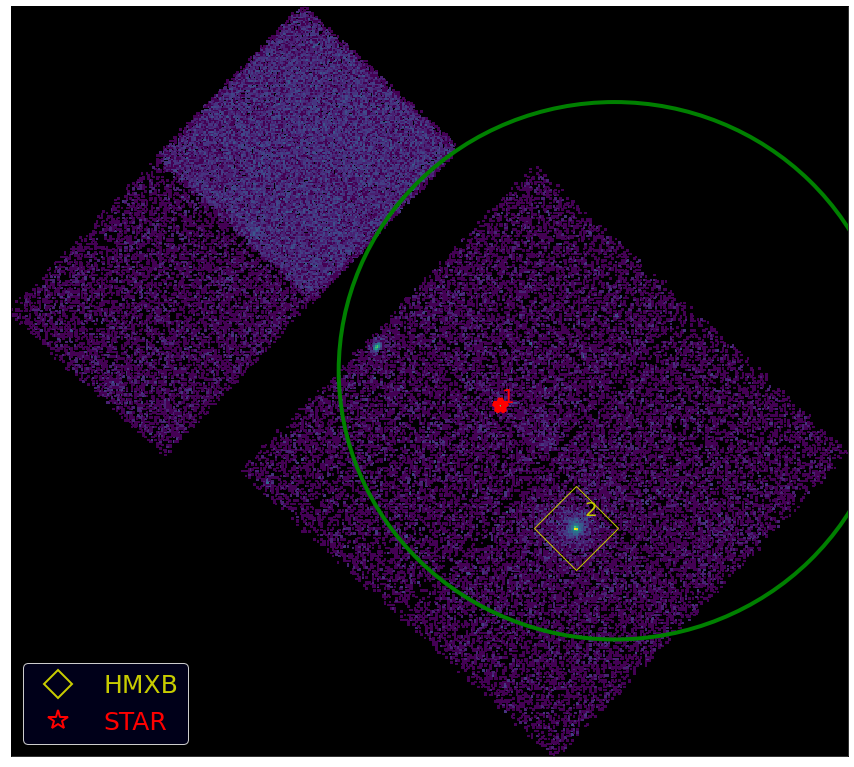

J1634-47


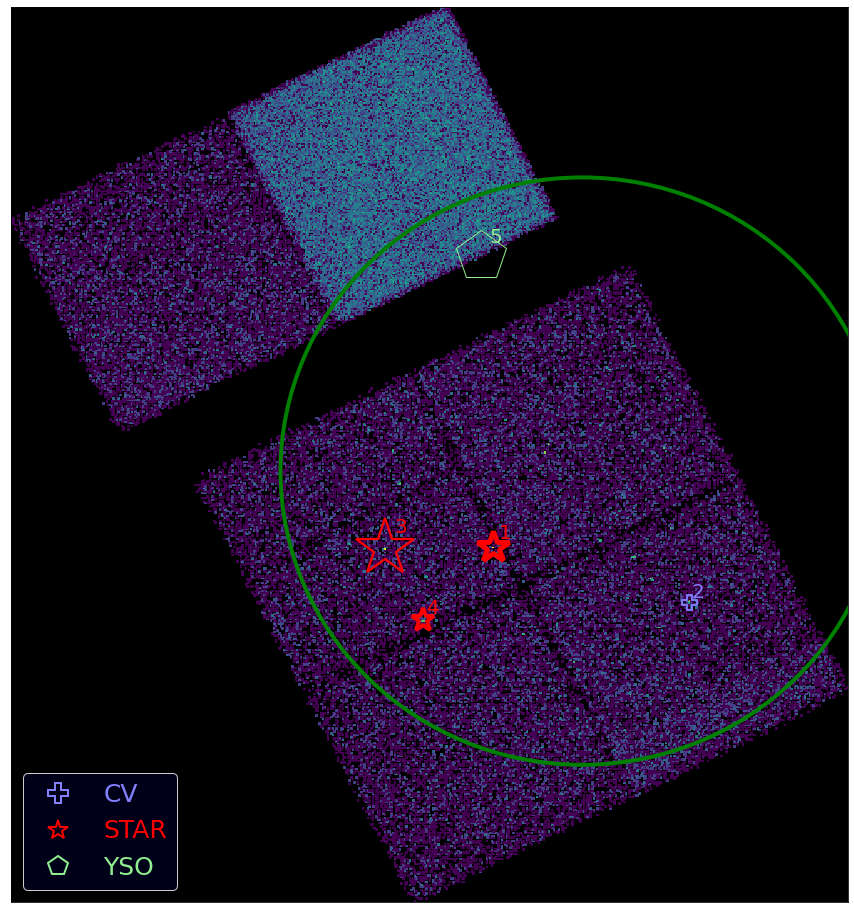

J1713-38


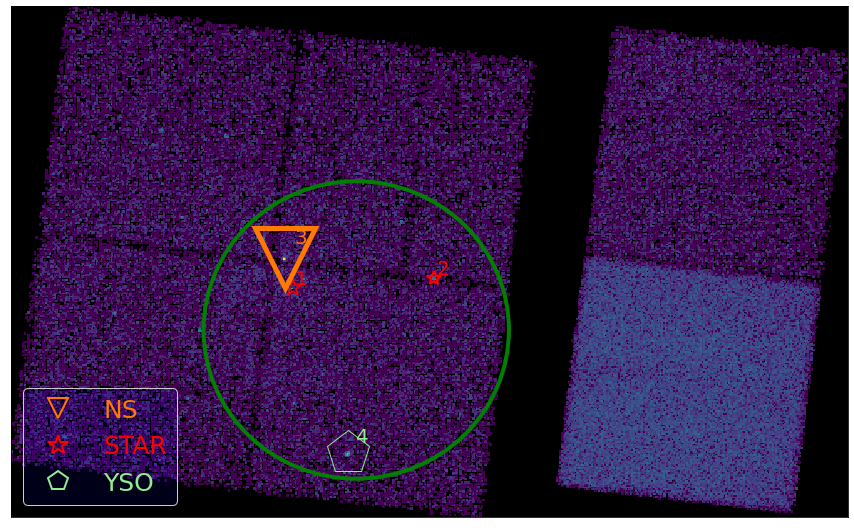

J1718-38


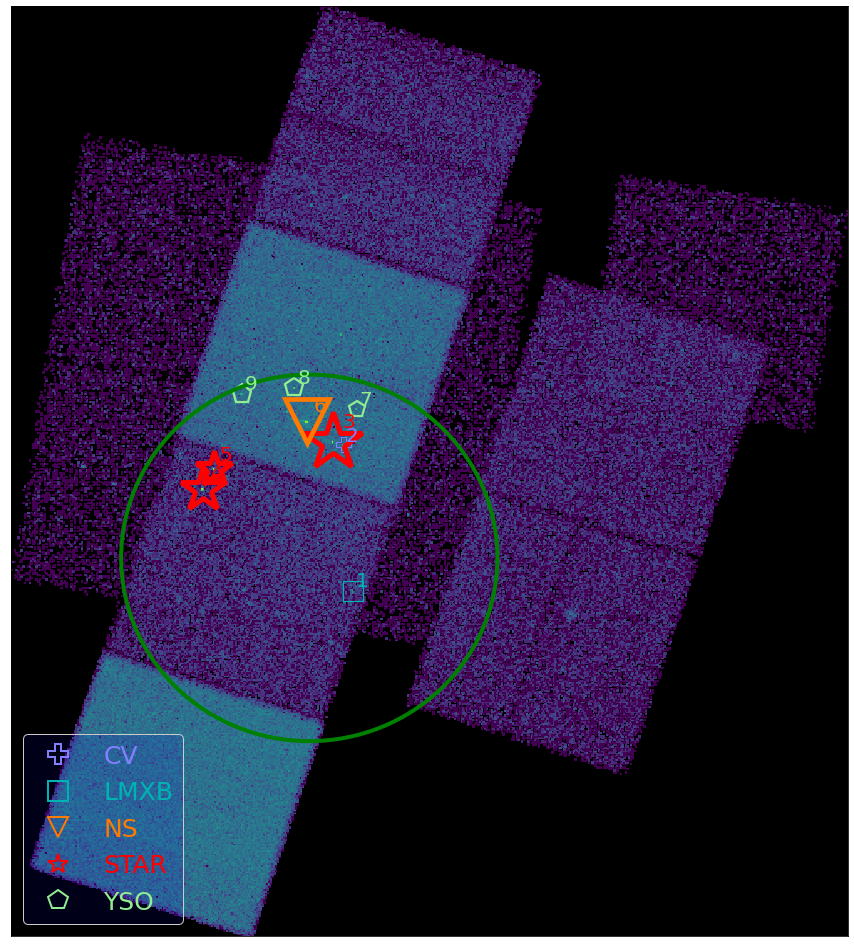

J1746-28


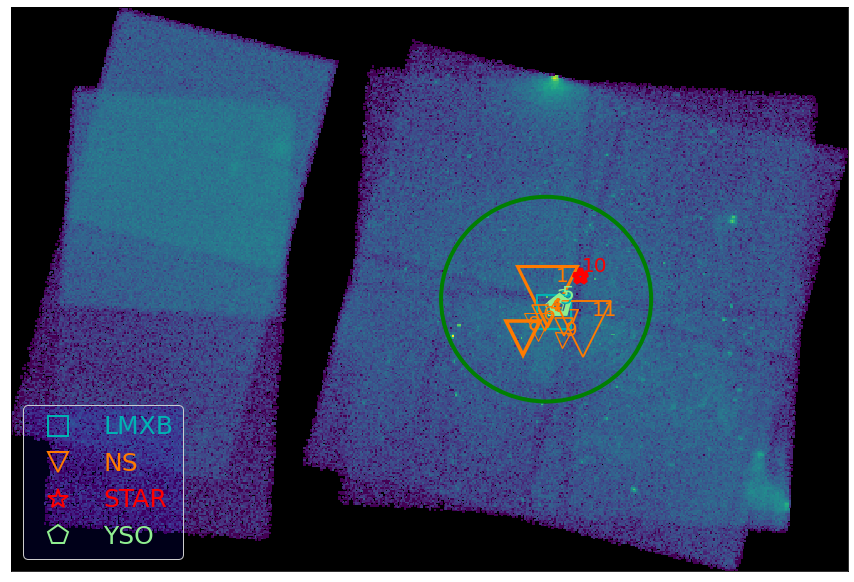

J1747-24


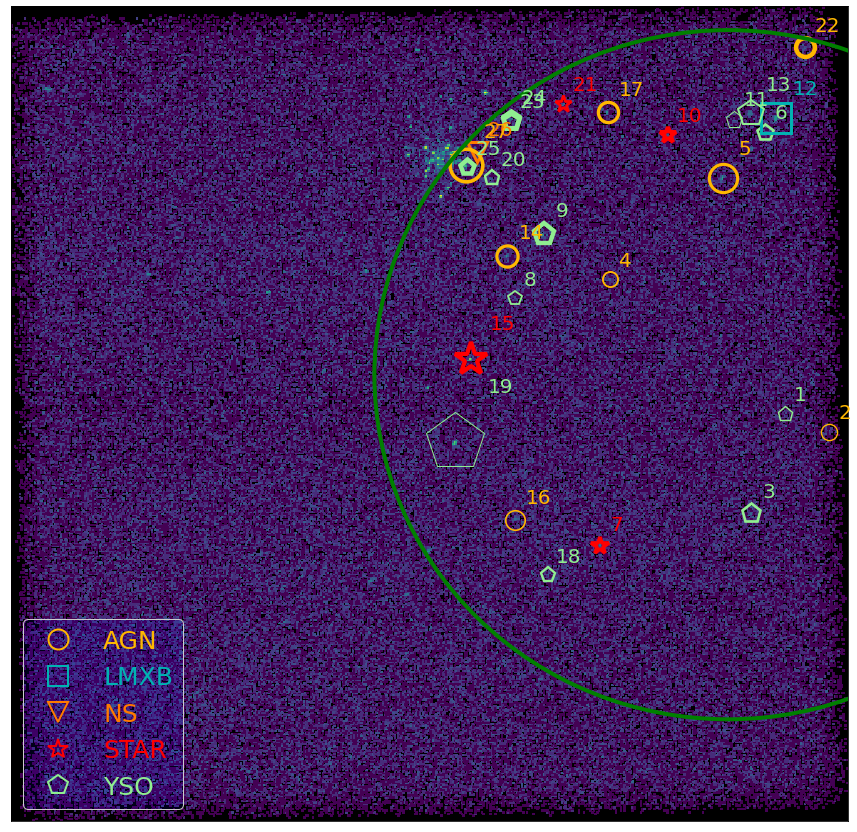

J1800-24


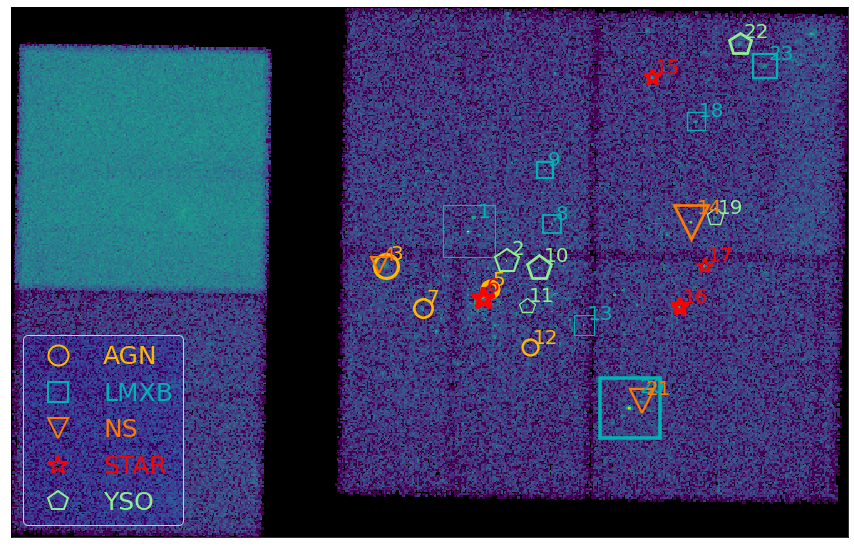

J1808-20


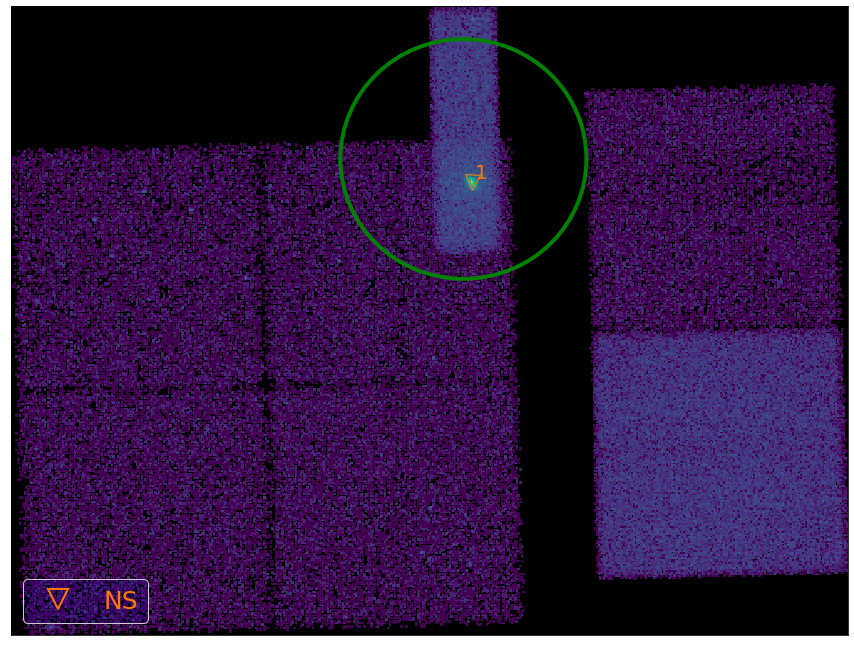

J1813-12


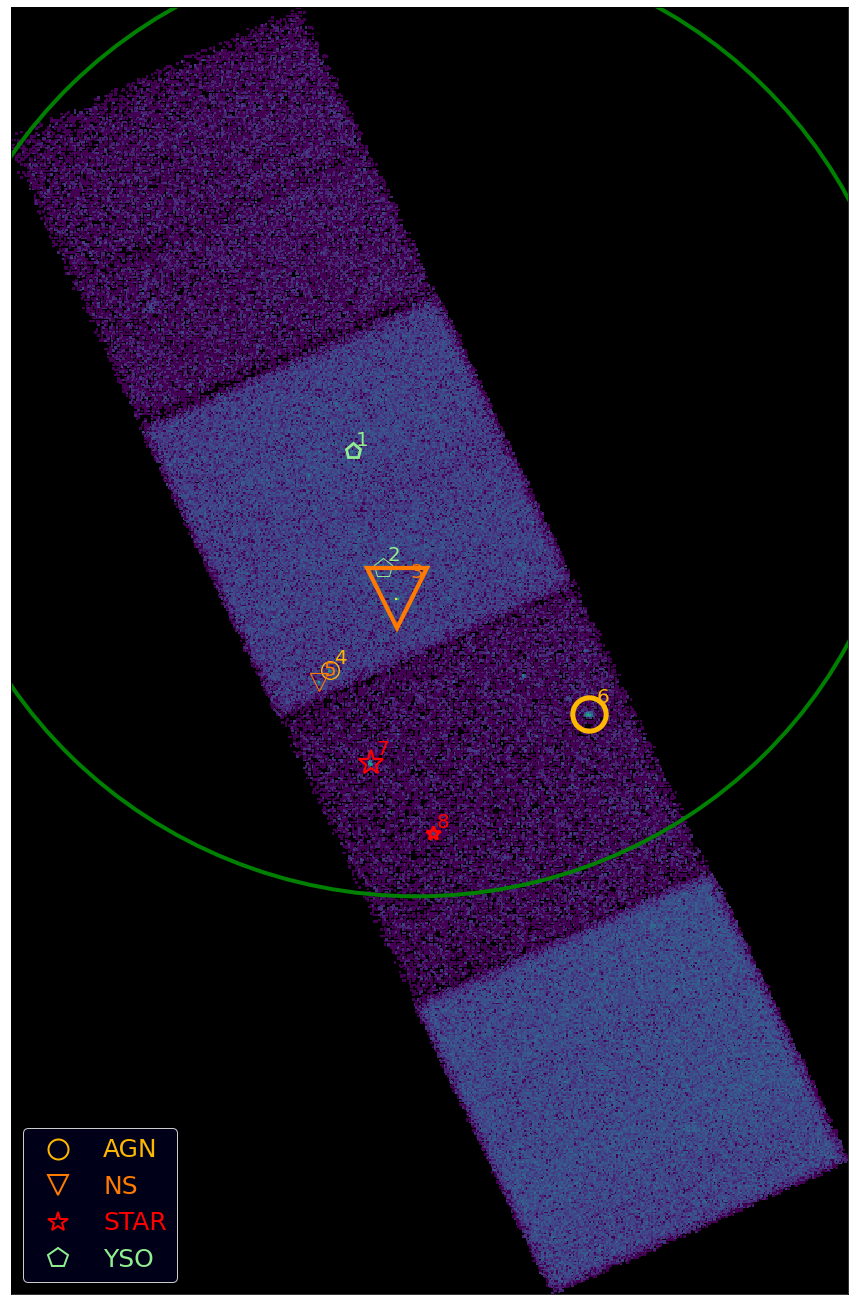

J1826-13


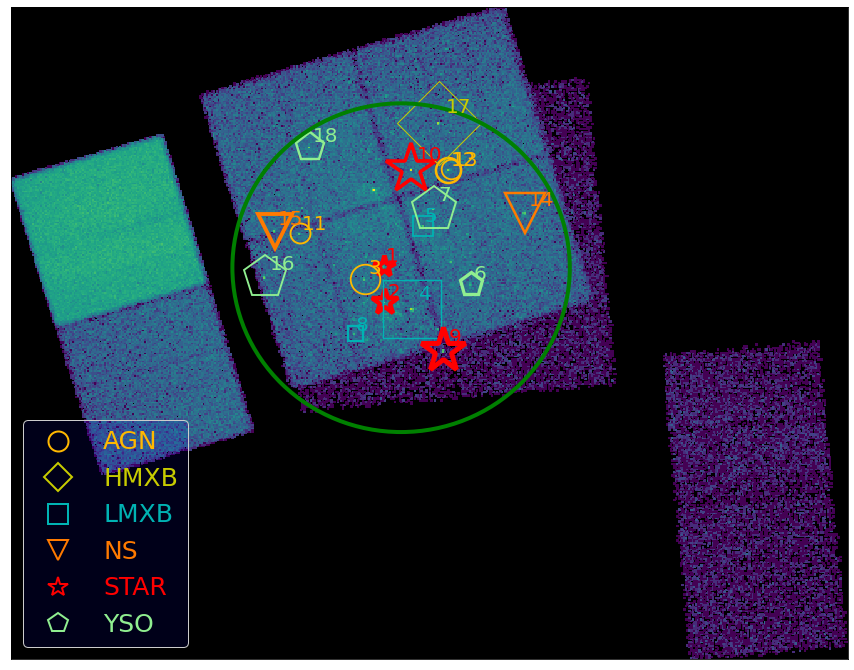

J1843-03


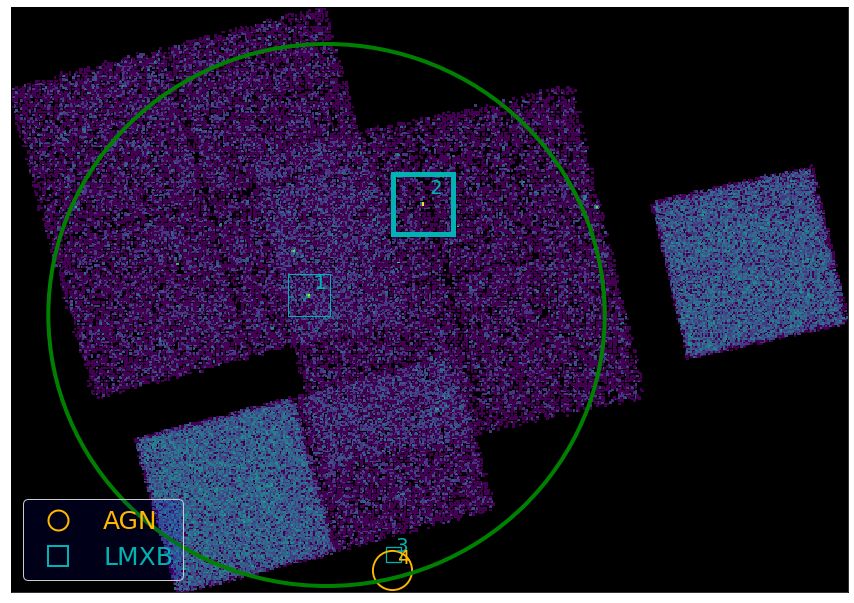

J1844-03


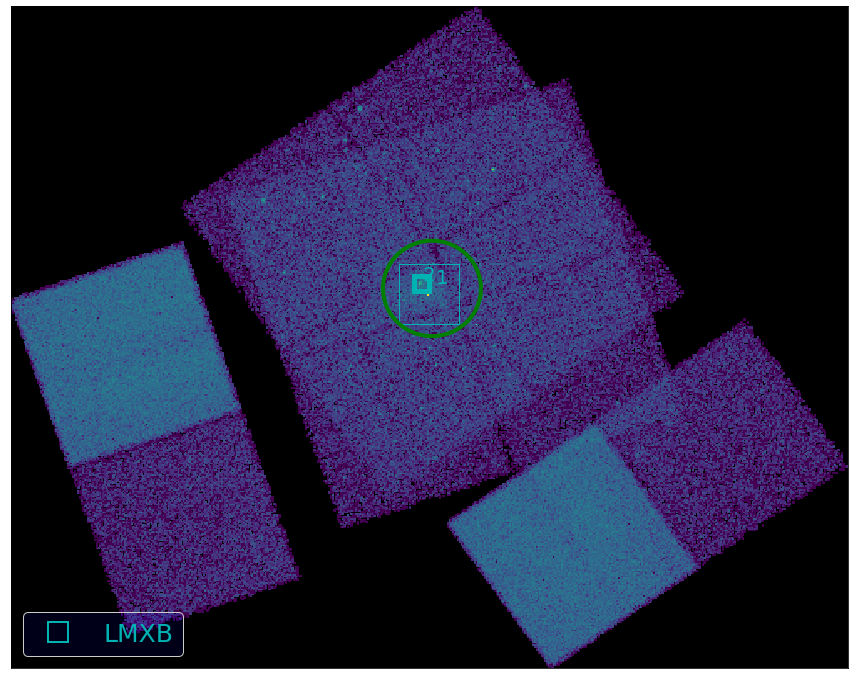

J1848-01


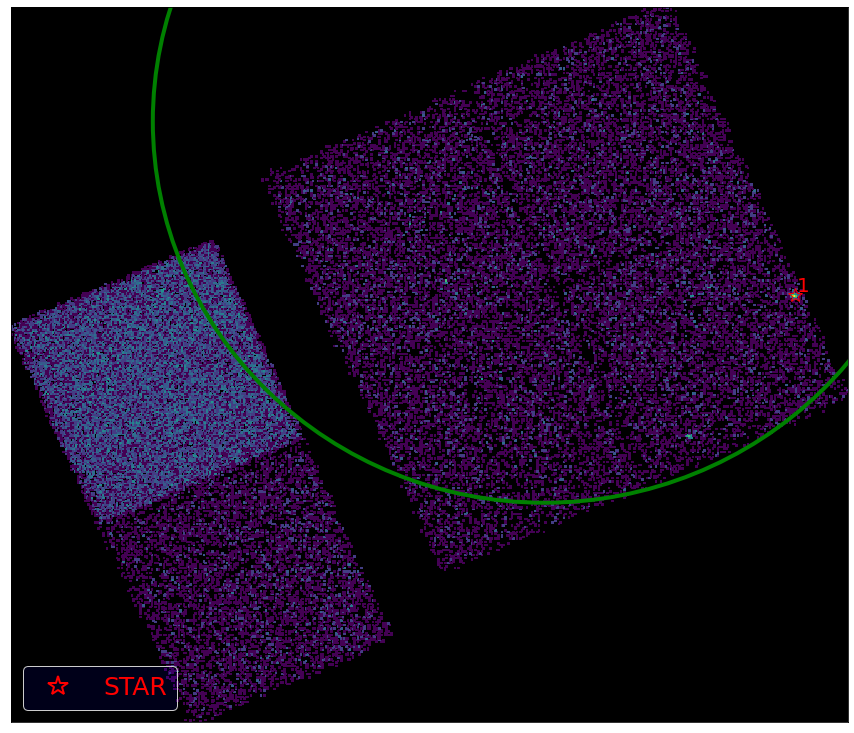

J1857+02


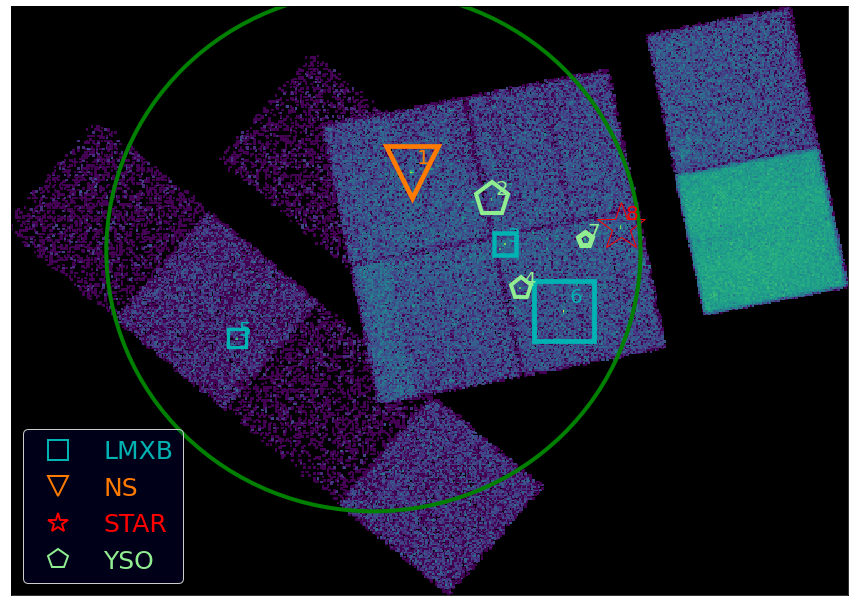

J1858+02


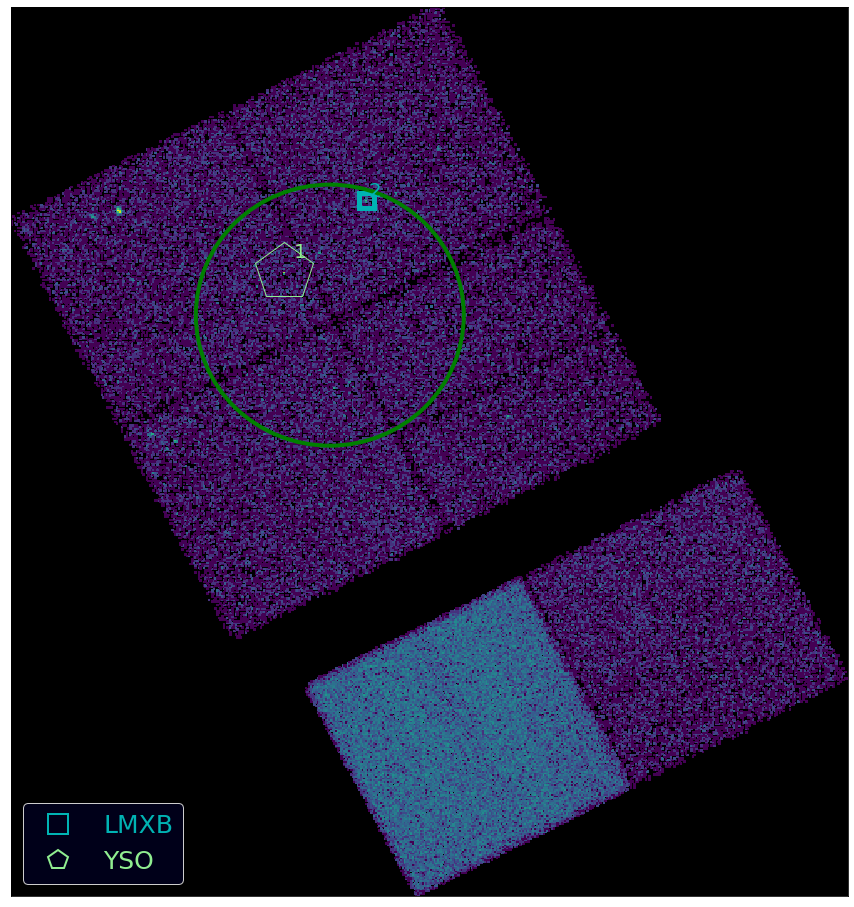

J1912+10


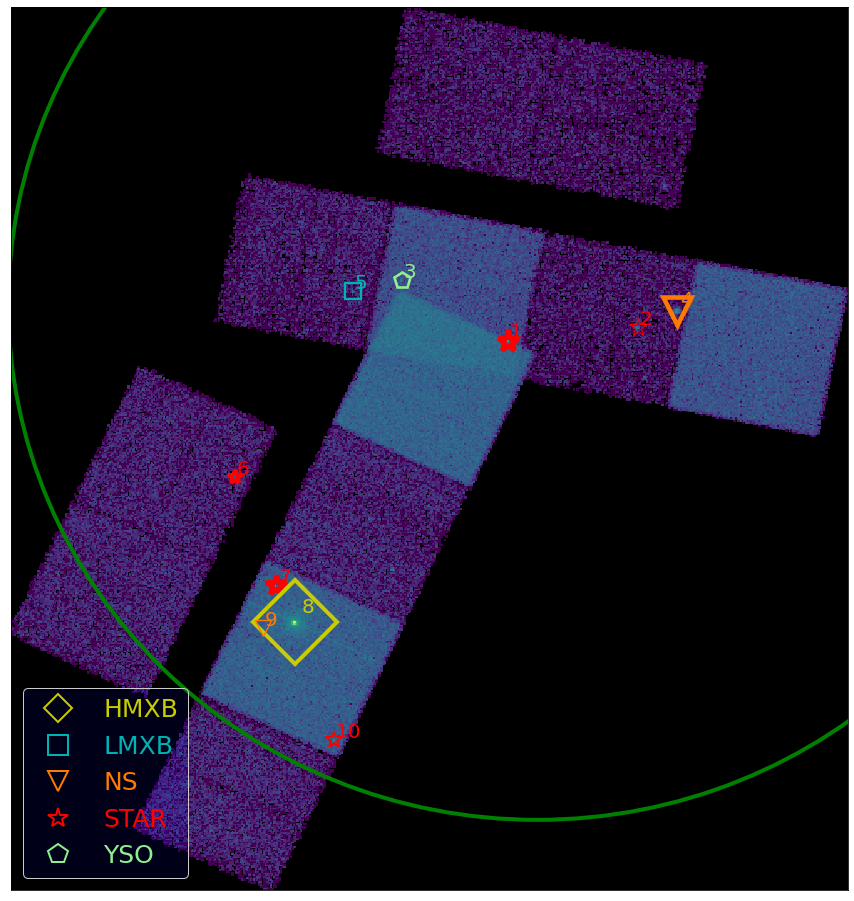

J1923+14


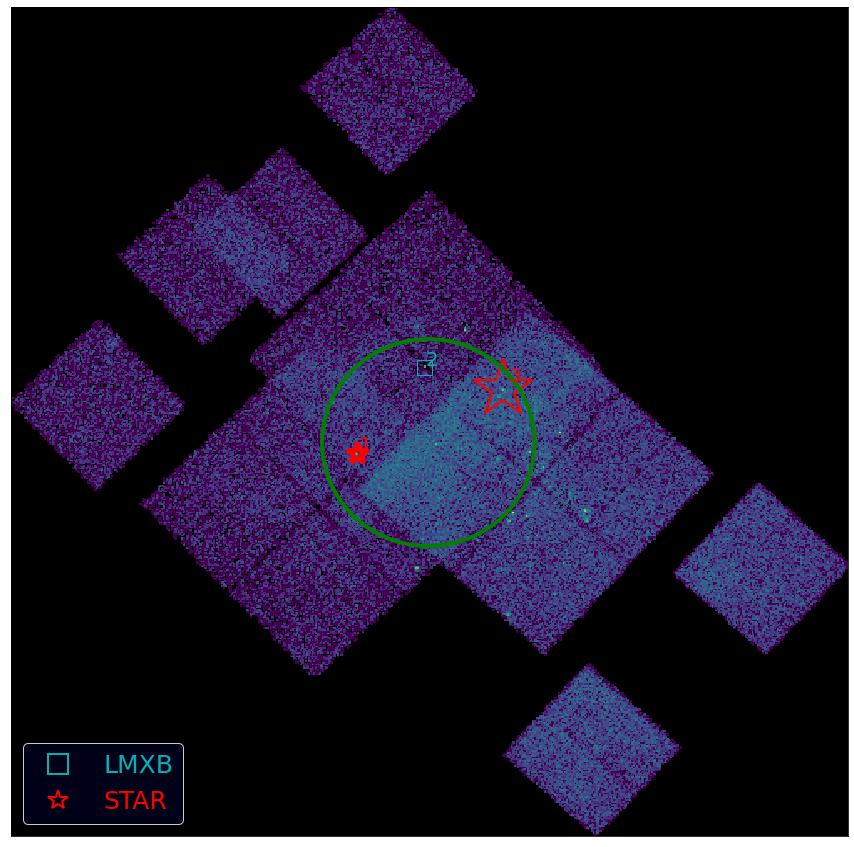

J1943+21


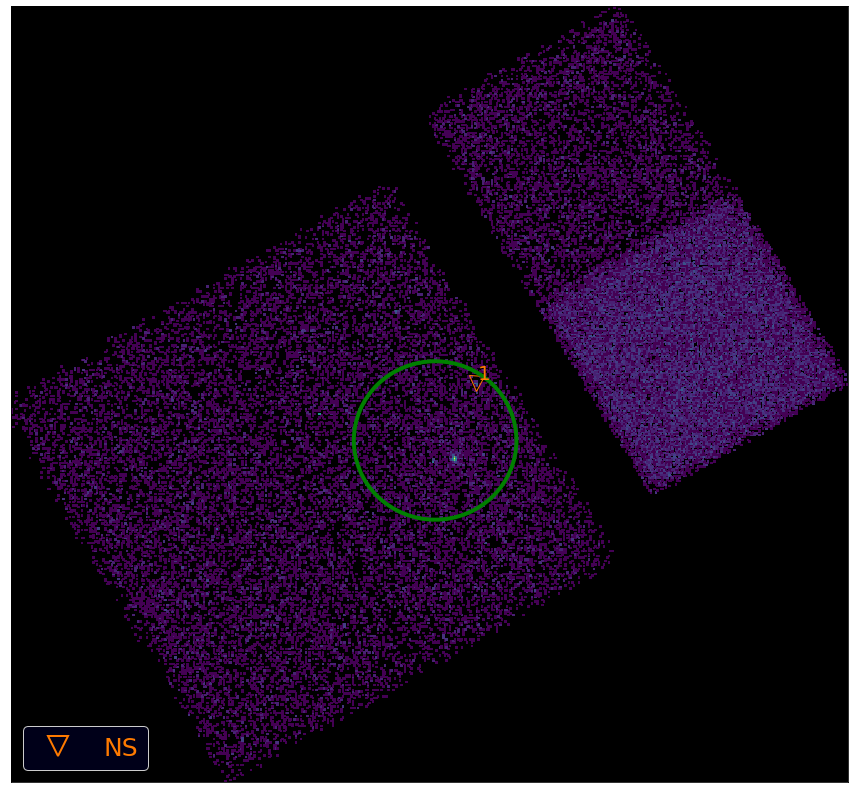

1

In [29]:
for obj in list(summary.keys()):
# for obj in ['J1746-28']:
        
    print(obj)

    fn_evt2 = obj_info[obj]
    # fits.info(fn_evt2)
    evt2_data, head = process_fits(fn_evt2)
        
    evt2_data = xy_filter_evt2(evt2_data)

    fn_csv = glob.glob(f'{HESS_dir}/{obj}*.csv')[0]
    dat_csv = pd.read_csv(fn_csv)

    x_min, x_max, y_min, y_max = evt2_data[0].min(), evt2_data[0].max(), evt2_data[1].min(), evt2_data[1].max()
    w, h = x_max - x_min, y_max - y_min 
    cntr = [(x_max + x_min)/2, (y_max + y_min)/2]

    d = ds9.DS9()

    d.set(f'fits {fn_evt2}')
    
    d.set(f'regions system physical')

    reg = 'regions command "'      

    for i, row in dat_csv.iterrows():

        ra, dec = [':'.join(row[_].strip().split()) for _ in ['ra', 'dec']]

        reg += f'point {ra} {dec}; '

    reg += '"'  

    d.set(reg)

    reg_phys = re.findall(r'\((.*?)\)', d.get('regions'))
    reg_phys = np.array([_.split(',') for _ in reg_phys]).astype(float)

#     sig = 25

    rmin = 5
    rmax = 20

    c_mx, c_mn = dat_csv['Class_prob'].max(), dat_csv['Class_prob'].min()
    if c_mx == c_mn: 
        c_mx = c_mn + 1
            
    s_mx, s_mn = dat_csv['significance'].max(), dat_csv['significance'].min()
    if s_mx == s_mn:
        s_mx = s_mn + 1 

    NBINS = (500, int(500 * h / w))

    # my_cmap = copy.copy(plt.cm.viridis)
    # my_cmap.set_under(1, 'k')

    fig, ax = plt.subplots(figsize=(15, 15 * h / w))
    ax.hist2d(evt2_data[0], evt2_data[1], NBINS, cmap='viridis', norm=LogNorm())

    ax.set_facecolor('k')

    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False) 

    # for point in reg_phys:
    #     plt.plot(*point, markersize=10, c='y', zorder=1, marker='o', markerfacecolor='None')

    for i, cat in dat_csv.iterrows():    

        ms = ((cat['significance'] - s_mn)/(s_mx - s_mn) * (rmax - rmin) + rmin ) * 3
#         ms = (0.5 * (rmax - rmin) + rmin) * 2.2
        width = 4 * (cat['Class_prob'] - c_mn) / (c_mx - c_mn) + 1
        color = colors_markers[cat['Class']][0]
        marker = colors_markers[cat['Class']][1]
        plt.plot(*reg_phys[i], 
                 marker, 
                 ms=ms, 
                 markerfacecolor='None',
                 markeredgecolor=color, 
                 markeredgewidth=width, 
                 label=cat['Class'], 
                 zorder=1)
        plt.text(reg_phys[i][0]+0.7*ms, 
                 reg_phys[i][1]+1.1*ms, 
                 f'{i+1}', 
                 fontsize=20, 
                 color=color)

    labels = list(np.sort(np.unique(dat_csv['Class'])))
    
    handles = [mlines.Line2D([], [], 
                             color=colors_markers[label][0], 
                             marker=colors_markers[label][1], 
                             linestyle='None', 
                             markerfacecolor='None',
                             markeredgewidth=2, 
                             markersize=20, 
                             label=label) 
               for label in labels]

    legend = plt.legend(handles=handles, loc='lower left', fontsize=25)
        
    for text, label in zip(legend.get_texts(), labels):
        text.set_color(colors_markers[label][0])
    
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    
#     GREEN CIRCLE
    l, b = summary[obj]['Gal l'], summary[obj]['Gal b']    
    rad = np.max([summary[obj]['Size'], summary[obj]['Unc']])
    x, y, rad2 = wcs_to_physical(fn_evt2, [l, b], rad, 'galactic')        
    draw_circle = plt.Circle((x, y), radius=rad2, color='g', zorder=1, lw=4, fill=False)    
    ax.add_artist(draw_circle)

    plt.savefig(f'{webdata_dir}/{obj}.jpeg', bbox_inches='tight', pad_inches=0) 

    plt.show()
    
d.set('exit')    

In [30]:
webjson = {}

for i, (k, v) in enumerate(summary.items()):
    
    table_image = glob.glob(f'{HESS_dir}/{k}*.png')[0]
    
    os.system(f'cp {table_image} {webdata_dir}/')
        
    webjson[k] = {
        'name': v['Name2'].split()[-1],
        'image': f'{k}.jpeg',
        'table_image': os.path.basename(table_image),
        'n_sources': n_sources_lst[i]
    }
    
    webjson[k].update(summary[k])
    
json.dump(webjson, open(f'{webdata_dir}/web.json', 'w'))    

In [31]:
webjson = json.load(open(f'{webdata_dir}/web.json'))   
# webjson

In [73]:
# weblabels = {k: v['Name2'].split()[-1] for k, v in summary.items()}

In [32]:
list(webjson.values())[0]

{'name': 'J1018-589B',
 'image': 'J1018-58.jpeg',
 'table_image': 'J1018-589.png',
 'n_sources': 1,
 'Name2': 'HESS J1018-589B',
 'Gal l': 284.22,
 'Gal b': -1.77,
 'Size': 9.0,
 'Unc': 7.0,
 'ObsIDs': ['14657', '11831']}

In [34]:
v

{'name': 'J1018-589B',
 'image': 'J1018-58.jpeg',
 'table_image': 'J1018-589.png',
 'n_sources': 1,
 'Name2': 'HESS J1018-589B',
 'Gal l': 284.22,
 'Gal b': -1.77,
 'Size': 9.0,
 'Unc': 7.0,
 'ObsIDs': ['14657', '11831']}

In [71]:
shapka = {

    'Webpage title': 'Multiwavelength Identification of Galactic High-Energy Sources',

    'Table title': 'Unidentified Galactic H.E.S.S. sources observed with Chandra X-ray Observatory.',

    'Table subtitle': 'Classifications of X-ray sources detected with CXO ACIS and located within the H.E.S.S. sources.',

    'Project goals': '''We plan to investigate the nature of particle accelerators in unidentified Galactic TeV gamma-ray sources with the aid of a comprehensive, 
    automated multi-wavelength (MW) analysis tool we developed. We focus on unidentified TeV sources in the Galactic plane (within 10 degrees from the plane) 
    that have been observed by Chandra and/or XMM-Newton and have a good-quality optical/IR and radio data. As the result of this project, we expect 
    to 
    <ol>
      <li>increase the number of identified gamma-ray sources,</li>
      <li>isolate a fraction of gamma-ray sources without plausible counterparts at other wavelengths (e.g. transients), </li>
      <li>gain insight into the particle acceleration processes in gamma-ray sources,</li>
      <li>classify a large number of Galactic X-ray sources.</li>
    </ol> ''',

    'Work performed': '''We collected  multwavelength properties of all X-ray sources in these fields using the Chandra X-ray Source catalog and multiwavelength properties from  Gaia-DR2, 2MASS, Spitzer, 
        and WISE catalogs. We used the machine-learning approach implemented in our MUWCLASS pipeline (see e.g., <a href='https://ui.adsabs.harvard.edu/abs/2020ApJ...901..157K/'>Klingler et al., 2020</a>). 
        The pipeline relies on the training dataset of ~10,000 X-ray sources that have known astrophysical types (currently these are STAR, YSO, WR star, AGN, LMXB, HMXB, CV, NS, NS binary). 
        We used this pipeline to classify 204 X-ray sources whose classifications are provided in the table below.''',

    'Funding support': 'This work is supported by the National Aeronautics and Space Administration (NASA) through the Astrophysics Data Analysis Program (ADAP) award 80NSSC19K0576.'
    
}    



In [62]:
shapka

{'Webpage title': 'Multiwavelength Identification of Galactic High-Energy Sources',
 'Table title': 'Unidentified Galactic H.E.S.S. sources observed with Chandra X-ray Observatory.',
 'Table subtitle': 'Classifications of X-ray sources detected with CXO ACIS and located within the H.E.S.S. sources.',
 'Project goals': 'We plan to investigate the nature of particle accelerators in unidentified Galactic TeV gamma-ray sources with the aid of a comprehensive, \n    automated multi-wavelength (MW) analysis tool we developed. We focus on unidentified TeV sources in the Galactic plane (within 10 degrees from the plane) \n    that have been observed by Chandra and/or XMM-Newton and have a good-quality optical/IR and radio data. As the result of this project, we expect \n    to (1) increase the number of identified gamma-ray sources, (2) isolate a fraction of gamma-ray sources without plausible counterparts at other wavelengths (e.g. transients), \n    (3) gain insight into the particle acceler

In [180]:
mode = [{'debug', 'production'}][0]

data_dir = 'webdata'

a = Airium()

a('<!DOCTYPE html>')

with a.html(lang="en"):
    
    with a.head():
        a.meta(charset='utf-8')    
        a.meta(name='viewport', content='width=device-width, initial-scale=1')
        a.title(_t=shapka['Webpage title'])
        
        if mode == 'debug':
            a.link(href='bootstrap-5.0.0-beta1-dist/css/bootstrap.min.css', rel='stylesheet')
        else:    
            a.link(href='https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/css/bootstrap.min.css',
                 rel='stylesheet',
                 integrity='sha384-giJF6kkoqNQ00vy+HMDP7azOuL0xtbfIcaT9wjKHr8RbDVddVHyTfAAsrekwKmP1',
                 crossorigin='anonymous')

#         
    
#         a.link(href='css/grid.css', rel='stylesheet')
    
#         a.style(
    
#         '''.themed-grid-col {
#           padding-top: .75rem;
#           padding-bottom: .75rem;
#           background-color: rgba(86, 61, 124, .15);
#           border: 1px solid rgba(86, 61, 124, .2);
#         }

#         .themed-container {
#           padding: .75rem;
#           margin-bottom: 1.5rem;
#           background-color: rgba(0, 123, 255, .15);
#           border: 1px solid rgba(0, 123, 255, .2);
#         }'''
#         )

        
    with a.body(klass="py-4"):
        with a.div(klass='container'):
            
            a.h1(_t=shapka['Webpage title'], klass='mb-5')
            
            a.h2(_t='Project goals')
            a.p(_t=shapka['Project goals'])
            
            a.h2(_t='Work performed')
            a.p(_t=shapka['Work performed'])
      
            a.h2(_t='Funding support')
            a.p(_t=shapka['Funding support'])
            
            
            with a.div(klass='sticky-top', style='z-index: 2; background-color: white;'):
                a.h4(_t=shapka['Table title'], klass='text-center mt-5')
                a.h5(_t=shapka['Table subtitle'], klass='text-center')

                a.p(_t='Click on the button to toggle between showing and hiding content.', klass='text-center')
            
#             a.button(
#                 klass='btn btn-primary', 
#                 type='button', 
#                 **{'data-bs-target': 'multi-collapse', 'data-bs-toggle': 'collapse'},
#                 onclick='console.log(this.name);this.name="Close Curtain";return false;',
#                 _t='expand all'
#             )

            
                a.a(klass='btn btn-outline-primary', 
                            _t = 'expand all',
                            href='.multi-collapse', 
                            role='button', 
                            **{'data-bs-toggle': 'collapse'})

#                 a.a(klass='btn btn-outline-primary', 
#                             _t = 'hide all',
#                             href='.multi-collapse', 
#                             role='button', 
# #                             onclick='console.log(this.name);this.name="Close Curtain";return false;',
#                             **{'data-bs-toggle': 'collapse'})
            
#             with a.button(klass='btn btn-primary', type='button', **{'data-bs-target': '.multi-collapse', 'data-bs-toggle': 'collapse'}):
#                     a('Toggle both elements')
            
                with a.div(klass='row gx-1 mb-1 justify-content-center sticky-top', style='z-index: 2; background-color: white;'):

                    a.div(klass='col themed-grid-col col-md-auto').p(_t='#')

                    a.div(klass='col themed-grid-col col-md-2').p(_t='HESS id') 

                    a.div(klass='col themed-grid-col col-md-1').p(_t='# of sources') 

                    a.div(klass='col themed-grid-col col-md-1').p(_t='Gal l') 

                    a.div(klass='col themed-grid-col col-md-1').p(_t='Gal b') 

                    a.div(klass='col themed-grid-col col-md-1').p(_t='Size') 

                    a.div(klass='col themed-grid-col col-md-1').p(_t='Unc') 

                    a.div(klass='col themed-grid-col col-md-2').p(_t='ObsIDs') 
                           
            for i, (k, v) in enumerate(webjson.items()):
                
                with a.div(klass='row gx-1 justify-content-center'):
                    
                    a.div(klass='col themed-grid-col col-md-auto').p(_t=f'{i+1}') 
                    
                    with a.div(klass='col themed-grid-col col-md-2 justify-content-center'): 

                        a.a(klass='btn btn-outline-primary text-center', 
                            _t = v['name'],
                            href=f'.row_{i}', 
                            role='button', 
                            **{'data-bs-toggle': 'collapse'})

                    with a.div(klass='col themed-grid-col col-md-1'):
                        
                        a.p(_t=f"{v['n_sources']}")    
                        
                    with a.div(klass='col themed-grid-col col-md-1'):
                        
                        a.p(_t=f"{v['Gal l']}")    

                    with a.div(klass='col themed-grid-col col-md-1'):
                        
                        a.p(_t=f"{v['Gal b']}")    
                        
                    with a.div(klass='col themed-grid-col col-md-1'):
                        
                        a.p(_t=f"{v['Size']}")   
                        
                    with a.div(klass='col themed-grid-col col-md-1'):
                        
                        a.p(_t=f"{v['Unc']}")  
                        
                    with a.div(klass='col themed-grid-col col-md-2'):
                    
#                         a.p(_t=f"{v['ObsIDs']}") 
                        
                        a.p(_t=', '.join(v['ObsIDs'])) 
                        

                with a.div(klass='row gx-2'):

                    with a.div(klass=f'col collapse multi-collapse row_{i}', id=f'row_{i}_img'):  
                        
                        a.img(src=f'{data_dir}/{v["image"]}', klass='img-fluid', alt="")
                            
                    with a.div(klass=f'col collapse multi-collapse row_{i}', id=f'row_{i}_tbl'):  
                        
                        a.img(src=f'{data_dir}/{v["table_image"]}', klass='img-fluid', alt="")
        if mode == 'debug':
            a.script(src='bootstrap-5.0.0-beta1-dist/js/bootstrap.bundle.min.js')
        else:    
            a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/js/bootstrap.bundle.min.js", 
                   integrity="sha384-ygbV9kiqUc6oa4msXn9868pTtWMgiQaeYH7/t7LECLbyPA2x65Kgf80OJFdroafW", 
                   crossorigin="anonymous")            

html = str(a) # casting to string extracts the value

open('website/index.html', 'w').write(html)      

# print(html)    

34274

In [182]:
%%html

<iframe src='http://localhost:5000' width="1200" height="1000"></iframe>

In [175]:
import http.server
import socketserver
import functools
import threading

PORT = 4444

os.chdir('website')

Handler = functools.partial(http.server.SimpleHTTPRequestHandler, directory=directory)

with socketserver.TCPServer(("", PORT), Handler) as httpd:
    print("serving at port", PORT)    
    thread = threading.Thread(target=httpd.serve_forever);
    thread.start()

serving at port 3333


In [177]:
pwd

'/Users/oyk100/Dropbox/oyk100ivv101/HESS_website'

In [175]:
import http.server
import socketserver
import functools
import threading

PORT = 3333

directory = 'website'

Handler = functools.partial(http.server.SimpleHTTPRequestHandler, directory=directory)

with socketserver.TCPServer(("", PORT), Handler) as httpd:
    print("serving at port", PORT)    
    thread = threading.Thread(target=httpd.serve_forever);
    thread.start()

serving at port 3333


In [168]:
!python -V

Python 3.7.7


In [167]:
Handler.directory

AttributeError: type object 'SimpleHTTPRequestHandler' has no attribute 'directory'

In [166]:
Handler.list_directory()

TypeError: list_directory() missing 2 required positional arguments: 'self' and 'path'

In [155]:
Handler.list_directory('self')

TypeError: list_directory() missing 1 required positional argument: 'path'

In [147]:
from http.server import *

In [ ]:
def run(server_class=http.server.HTTPServer, handler_class=http.server.BaseHTTPRequestHandler):
    server_address = ('', 3333)
    httpd = server_class(server_address, handler_class)
    httpd.serve_forever()

In [149]:
import http.server

PORT = 3333
httpd = http.server.SimpleHTTPRequestHandler(('', PORT), directory='website')
httpd.serve_forever()

TypeError: __init__() missing 2 required positional arguments: 'client_address' and 'server'

In [238]:
# a = Airium()

# a('<!DOCTYPE html>')

# with a.html(lang="en"):
#     with a.head():
#         a.meta(charset='utf-8')    
#         a.meta(name='viewport', content='width=device-width, initial-scale=1')
#         a.title(_t='HESS')

#     #     a.link(href='https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/css/bootstrap.min.css',
#     #          rel='stylesheet',
#     #          integrity='sha384-giJF6kkoqNQ00vy+HMDP7azOuL0xtbfIcaT9wjKHr8RbDVddVHyTfAAsrekwKmP1',
#     #          crossorigin='anonymous')

#         a.link(href='bootstrap-5.0.0-beta1-dist/css/bootstrap.min.css', rel='stylesheet')

#     with a.body():
        
#         with a.div(klass='container'):            

#             for i in ['home', 'about', 'contact']:
#                     a.li(_t=i, href='/%s.html' % i)

#             with a.div(klass='body'):
#                 a.p(_t='Lorem ipsum..')

#             a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/js/bootstrap.bundle.min.js", 
#                      integrity="sha384-ygbV9kiqUc6oa4msXn9868pTtWMgiQaeYH7/t7LECLbyPA2x65Kgf80OJFdroafW", 
#                      crossorigin="anonymous")

# #             a.script(href='bootstrap-5.0.0-beta1-dist/js/bootstrap.bundle.min.js')

    

# html = str(a) # casting to string extracts the value

# open('website/test.html', 'w').write(html)      

# print(html)


In [ ]:
# NBINS = (500, 500)

# # my_cmap = copy.copy(plt.cm.viridis)
# # my_cmap.set_under(1, 'k')

# fig, ax = plt.subplots(figsize=(15, 15 * h / w))
# ax.hist2d(evt2_data['x'], evt2_data['y'], NBINS, cmap='viridis', norm=LogNorm())

# ax.set_facecolor('k')

# ax.get_xaxis().set_visible(False) 
# ax.get_yaxis().set_visible(False) 

# for point in reg_phys:
#     plt.plot(*point, markersize=10, c='y', zorder=1, marker='o', markerfacecolor='None')

# plt.savefig(f'foo.jpeg', bbox_inches='tight', pad_inches=0) 

# plt.show()

In [ ]:
# d = ds9.DS9()

# ds9_commands = [
    
#     f'fits {fn_evt2}',  
    
#     'bin to fit',
    
#     'zoom to fit',
        
#     f'crop {(x_max+x_min)/2} {(y_max+y_min)/2} {x_max-x_min} {y_max-y_min} physical', 
    
#     'smooth radius 2',  
    
#     'scale log exp 10',
   
#     'scale log',
    
#     'cmap Sls',
       
#     'zscale contrast 0.25'
# ]
# [d.set(_) for _ in ds9_commands]

# d.set(f'regions command "physical; box {(x_max+x_min)/2} {(y_max+y_min)/2} {x_max-x_min} {y_max-y_min} # color=yellow"')

# for index, row in dat_csv.iterrows():
    
#     ra, dec = [':'.join(row[_].strip().split()) for _ in ['ra', 'dec']]
        
#     d.set(f'regions command "fk5; circle {ra} {dec} 0.01 # color=yellow"')
    
# # d.set(f'export png {obj}.png'),
# # d.set('saveimage jpeg foo.jpeg 100')

# # d.set('frame new')

# # d.set('exit')

In [ ]:
# class2col = {'STAR': 'black',
#             'AGN': 'white',
#             'ATNF': 'red',
#             'YSO': 'green',
#             'LMXB': 'blue',
#             'WR': 'cyan',
#             'CV': 'magenta',
#             'ATNF BIN': 'yellow',
#             'HMXB': 'orange',
#             'NS': 'purple'}

# class2col["ATNF_BIN"] = class2col["ATNF BIN"]

In [116]:
# import dominate
# from dominate.tags import *

# doc = dominate.document(title='Dominate your HTML')

# with doc.head:
#     link(rel='stylesheet', href='style.css')
#     script(type='text/javascript', src='script.js')

# with doc:
#     with div(id='header').add(ol()):
#         for i in ['home', 'about', 'contact']:
#             li(a(i.title(), href='/%s.html' % i))

#     with div():
#         attr(cls='body')
#         p('Lorem ipsum..')

# print(doc)

In [227]:
# doc = dominate.document(title='HESS')



# # doc.add_raw_string(r'<html lang="en">')
# # doc.html(lang="en")

# with doc.head:
#     meta(charset='UTF-8')    
#     meta(name='viewport', content='width=device-width, initial-scale=1')
         
# #     link(href='https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/css/bootstrap.min.css',
# #          rel='stylesheet',
# #          integrity='sha384-giJF6kkoqNQ00vy+HMDP7azOuL0xtbfIcaT9wjKHr8RbDVddVHyTfAAsrekwKmP1',
# #          crossorigin='anonymous')
       
#     link(href='bootstrap-5.0.0-beta1-dist/css/bootstrap.min.css', rel='stylesheet')
    
# with doc.add(div(cls='container')):
       
#     for i in ['home', 'about', 'contact']:
#             li(a(i.title(), href='/%s.html' % i))

#     with div():
#         attr(cls='body')
#         p('Lorem ipsum..')

# open('website/test.html', 'w').write(doc.render())        
# print(doc.render())

In [228]:
# !airium website/collapsible3.html

In [39]:
# sum(arr, []) -- flatten list of lists

In [40]:
# fn = '/Users/oyk100/Dropbox/oyk100ivv101/HESS_website/evt2/merged/3841/primary/orbitf155563500N001_eph1.fits.gz'

# fits.info(fn)
# fits.getheader(fn,ext=1)

# image_data = fits.getdata(fn)

# fig = plt.subplots(figsize=(20,20))
# plt.imshow(image_data, cmap='viridis', vmin=0, vmax=3)
# plt.colorbar()

In [41]:
# for i, row in dat_csv.iterrows():

#         ra, dec = [':'.join(row[_].strip().split()) for _ in ['ra', 'dec']]
        
# ra, dec

In [ ]:
# colors_markers = {
#     'STAR': ['black', '*'], 
#     'AGN': ['white', 'o'],         
#     'YSO': ['lime', 'p'], 
#     'LMXB': ['blue', 'v'],         
#     'CV': ['magenta', 'x'],         
#     'HMXB': ['orange', 'D'], 
#     'NS': ['red', 's'], 
#     'NS_BIN': ['red', 'P'],

#     'ATNF_BIN': ['yellow', 'P'], 
#     'ATNF': ['yellow', 's'],
#     'WR': ['cyan', '^']
# }

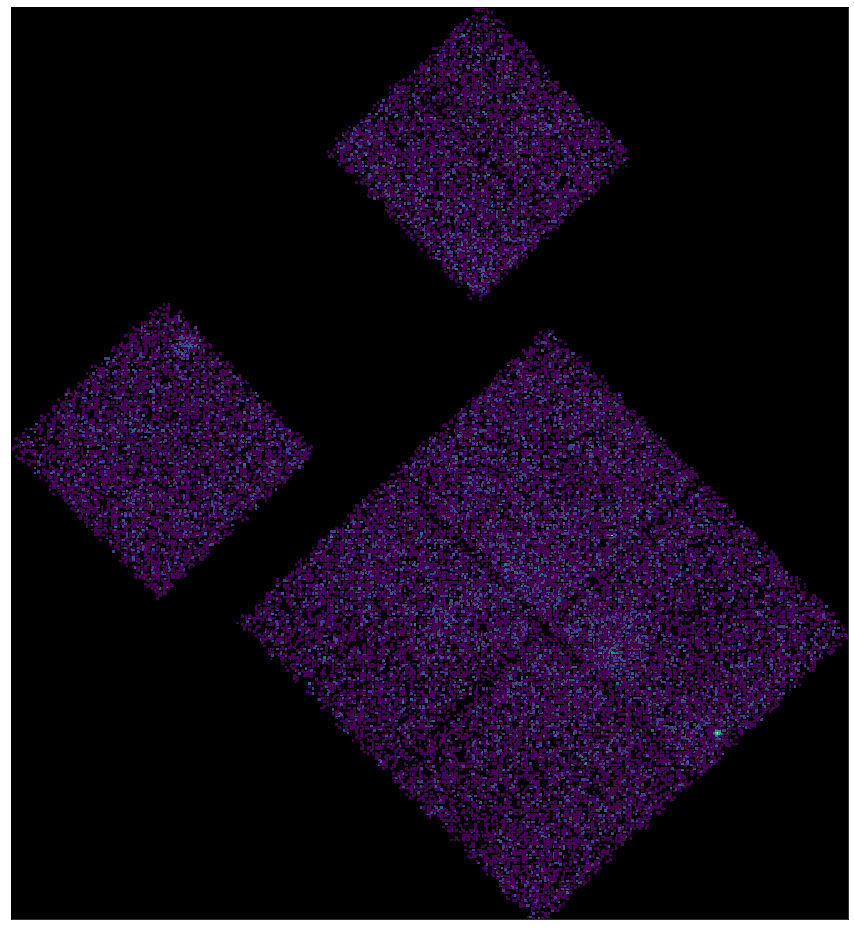

In [29]:
obsid = list(obsids_info.keys())[-2]

fn_evt2 = obsids_info[obsid]['fn']
# fits.info(fn_evt2)
evt2_data, head = process_fits(fn_evt2)

evt2_data = xy_filter_evt2(evt2_data)

x_min, x_max, y_min, y_max = evt2_data[0].min(), evt2_data[0].max(), evt2_data[1].min(), evt2_data[1].max()
w, h = x_max - x_min, y_max - y_min 
cntr = [(x_max + x_min)/2, (y_max + y_min)/2]

NBINS = (500, int(500 * h / w))

# my_cmap = copy.copy(plt.cm.viridis)
# my_cmap.set_under(1, 'k')

fig, ax = plt.subplots(figsize=(15, 15 * h / w))
h = ax.hist2d(evt2_data[0], evt2_data[1], NBINS, cmap='viridis', norm=LogNorm(), density=False)

# rgb_default = make_lupton_rgb(i, r, g, filename="ngc6976-default.jpeg")
# plt.imshow(rgb_default, origin='lower')

ax.set_facecolor('k')

ax.get_xaxis().set_visible(False) 
ax.get_yaxis().set_visible(False) 
plt.show()


In [279]:
xy_df = pd.DataFrame(evt2_data.T, columns=['x', 'y'])

x            y
0      3191.681152  4378.995605
1      3773.084961  3117.854980
2      3894.226807  3515.368408
3      4509.243164  3177.852051
4      2124.355225  5191.717285
...            ...          ...
42157  4023.523193  2873.225342
42158  4404.097656  3279.058594
42159  4184.238770  3529.312256
42160  4115.956055  3885.405029
42161  2498.160400  4366.093262

[42162 rows x 2 columns]

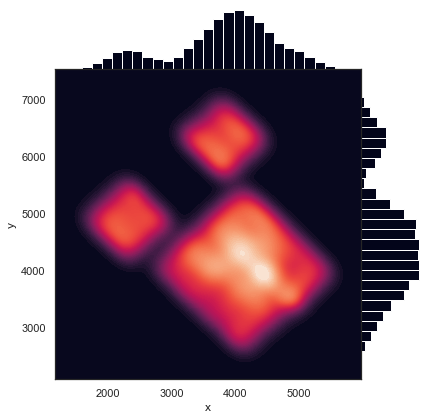

In [281]:
import seaborn as sns
sns.set_theme(style="white")

# df = sns.load_dataset("penguins")

g = sns.JointGrid(data=xy_df, x="x", y="y", space=0)
# g.plot_joint(sns.kdeplot,
#              fill=True, clip=((2200, 6800), (10, 25)),
#              thresh=0, levels=100, cmap="rocket")

g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")

g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

<AxesSubplot:>

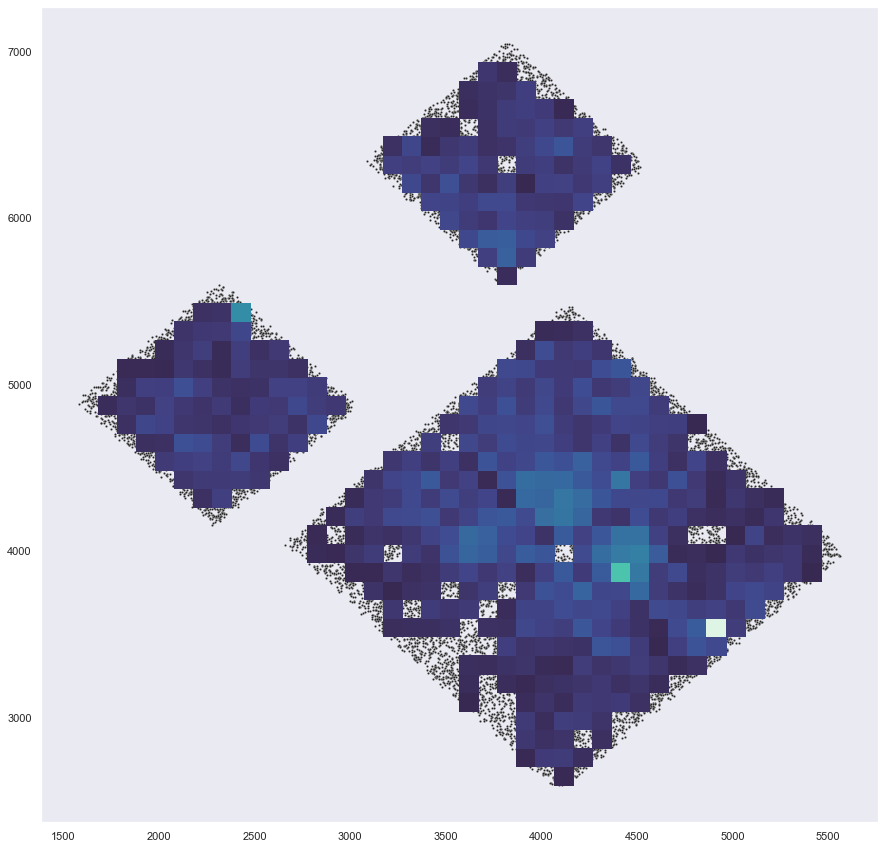

In [297]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian
# n = 10000
# mean = [0, 0]
# cov = [(2, .4), (.4, .2)]
# rng = np.random.RandomState(0)
# x, y = rng.multivariate_normal(mean, cov, n).T

x, y = evt2_data

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=40, pthresh=.1, cmap="mako")
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

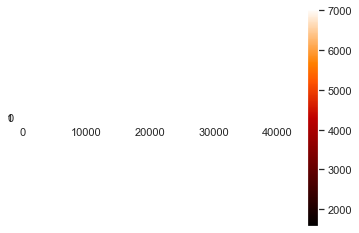

In [333]:
import smoothy
smoothy.io.graph.visualize(evt2_data)

[[<matplotlib.lines.Line2D at 0x7f9fedb08190>],

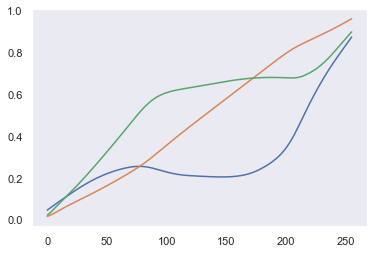

In [328]:
[plt.plot(_) for _ in np.transpose(sns.cm.mako.colors)]

In [30]:
# import xseer

In [31]:
#     # This loads the denoising model from tensorflow into the backend

# spectra = xseer.Seer(fn_evt2)    # This creates a Seer object, which allows the model to perform computations on the spectra

# spectra.denoise()   # This applies the denoising model to the spectra, saving the denoised flux vector as an object attribute

# spectra.show()  # This plots the original spectra (in blue) and the new, denoised spectra (in orange) for visual comparision
#                 # It can also be called before denoising, to just plot the original spectra

# spectra.save()  # This saves the denoised spectra to a new file. You can specify a filename, but it defaults to saving the spectra
#                 # to 'xseer_spec_<filename>.fits'

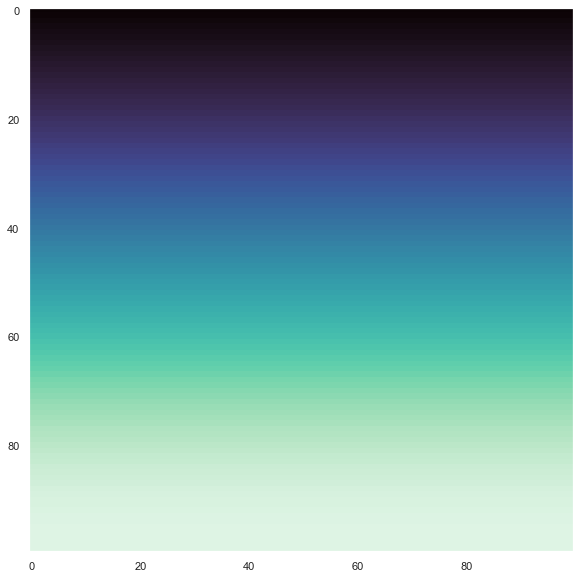

In [327]:
x = np.linspace(-0.5,0.5,100)
y = np.linspace(-3,0,100)
X, Y = np.meshgrid(x,y)

def f(x, y):
    return 1./(1+0.001j*(x-100j*y**2))



fig = plt.figure(figsize=(10,10))
plt.imshow(np.abs(f(X,Y)), cmap=sns.cm.mako)
plt.show()

In [107]:
# def show_evt2(obsid, path='.', ccd=-1):
    
#     url, fn = get_evt2_file(obsid, path)
    
#     evt2_data, evt2_head = process_fits(fn)
    
#     xy_unscaled = xy_evt2(evt2_data)
    
#     xmin, ymin = np.min([np.min(_, axis=1) for _ in xy_unscaled.values()], axis=0)
#     xmax, ymax = np.max([np.max(_, axis=1) for _ in xy_unscaled.values()], axis=0)

#     w, h = xmax - xmin, ymax - ymin

#     bounds = xmin, xmax, ymin, ymax

#     xx = []
#     yy = []

#     for [x, y] in xy_unscaled.values():

#         xx = np.append(xx, x)
#         yy = np.append(yy, y)

#     arr = np.array([xx, yy]).T
    
#     data = np.histogram2d(*arr.T, bins=250)[0]
#     data = gaussian_filter(data, sigma=.5)

# #     gamma_corrected = exposure.adjust_gamma(data, 2)
# #     logarithmic_corrected = exposure.adjust_log(data, 0.1)
    
#     fig, ax = plt.subplots(facecolor='k', figsize=(15, 15*h/w))

#     cmap = 'Blues_r'
#     plt.pcolormesh(np.log(data + 1).T, cmap=cmap, shading='flat')
# #     plt.pcolormesh(data.T, cmap=cmap, shading='flat')
    
# #     plt.imshow(np.log(data + 1).T, cmap=cmap, aspect='auto')
# #     plt.imshow(logarithmic_corrected.T, cmap=cmap, aspect='auto')

#     plt.axis('off') 
#     ax.get_xaxis().set_visible(False) 
#     ax.get_yaxis().set_visible(False) 

#     plt.show()
    
#     fig, ax = plt.subplots(facecolor='k', figsize=(10, 10*h/w))

#     [ax.scatter(*xy_unscaled[ccd], s=0.1, c=[[56/255, 117/255, 174/255]]) for ccd in xy_unscaled.keys()]

#     ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], c='r')

#     ax.set_xlim(xmin, xmax)
#     ax.set_ylim(ymin, ymax)
    
#     plt.axis('off') 
#     ax.get_xaxis().set_visible(False) 
#     ax.get_yaxis().set_visible(False) 

#     plt.show()
    
#     return # show_evt2

In [132]:
a = Airium()

a('<!DOCTYPE html>')

with a.html(lang="en"):
    
    with a.head():
        a.meta(charset='utf-8')    
        a.meta(name='viewport', content='width=device-width, initial-scale=1')
        a.title(_t='HESS')

#         a.link(href='https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/css/bootstrap.min.css',
#              rel='stylesheet',
#              integrity='sha384-giJF6kkoqNQ00vy+HMDP7azOuL0xtbfIcaT9wjKHr8RbDVddVHyTfAAsrekwKmP1',
#              crossorigin='anonymous')

        a.link(href='bootstrap-5.0.0-beta1-dist/css/bootstrap.min.css', rel='stylesheet')
        
    with a.body():
        with a.div(klass='container'):
            
            a.h2(_t='HESS')
            
            a.p(_t='Click on the button to toggle between showing and hiding content.')
            
            with a.button(klass='btn btn-info', 
                          type='button', 
                          **{'data-bs-target': '#demo', 'data-bs-toggle': 'collapse'}):
                
                a('Simple collapsible')
                
            with a.div(klass='collapse', id='demo'):
                a('Lorem ipsum dolor sit amet, consectetur adipisicing elit')
                  
            with a.p():
                with a.a(klass='btn btn-primary', href='#multiCollapseExample1', role='button', **{'data-bs-toggle': 'collapse'}):
                    a('Toggle first element')
                  
                with a.button(klass='btn btn-primary', type='button', **{'data-bs-target': '#multiCollapseExample2', 'data-bs-toggle': 'collapse'}):
                    a('Toggle second element')
                  
                with a.button(klass='btn btn-primary', type='button', **{'data-bs-target': '.multi-collapse', 'data-bs-toggle': 'collapse'}):
                    a('Toggle both elements')
                  
            with a.div(klass='row'):
                
                with a.div(klass='col'):
                  
                    with a.div(klass='collapse multi-collapse', id='multiCollapseExample1'):
#                         with a.div(klass='card card-body'):
                            a.img(src="CXO_coverage.png", alt="")
#                             a('Lorem ipsum dolor sit amet, consectetur adipisicing elit') 
                            
                with a.div(klass='col'):
                    
                    with a.div(klass='collapse multi-collapse', id='multiCollapseExample2'):
                        with a.div(klass='card card-body'):
                            a('Lorem ipsum dolor sit amet, consectetur adipisicing elit')
                  

                
                
#                  with a.div(klass='col'):
                  
#                     with a.div(klass='collapse multi-collapse', id='multiCollapseExample1'):
#                         with a.div(klass='card card-body'):
#                             a('Anim pariatur cliche reprehenderit, enim eiusmod high life accusamus terry richardson ad squid. Nihil anim keffiyeh helvetica, craft beer labore wes anderson cred nesciunt sapiente ea\n                        proident.')
                
#                 with a.div(klass='col'):
                    
#                     with a.div(klass='collapse multi-collapse', id='multiCollapseExample2'):
#                         with a.div(klass='card card-body'):
#                             a('Anim pariatur cliche reprehenderit, enim eiusmod high life accusamus terry richardson ad squid. Nihil anim keffiyeh helvetica, craft beer labore wes anderson cred nesciunt sapiente ea\n                        proident.')

#         a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/js/bootstrap.bundle.min.js", 
#                integrity="sha384-ygbV9kiqUc6oa4msXn9868pTtWMgiQaeYH7/t7LECLbyPA2x65Kgf80OJFdroafW", 
#                crossorigin="anonymous")

        a.script(src='bootstrap-5.0.0-beta1-dist/js/bootstrap.bundle.min.js')

html = str(a) # casting to string extracts the value

open('website/test.html', 'w').write(html)      

# print(html)                            

1760

In [143]:
# from IPython.display import IFrame

# IFrame(src='http://localhost:5000/HESS.html', width=700, height=600)

In [139]:
IPython.display.HTML('<frame src="website/hess.html?raw=1  width="1200" height="1000""></iframe>') 

In [230]:
# data_dir = 'webdata'

# a = Airium()

# a('<!DOCTYPE html>')

# with a.html(lang="en"):
    
#     with a.head():
#         a.meta(charset='utf-8')    
#         a.meta(name='viewport', content='width=device-width, initial-scale=1')
#         a.title(_t='HESS')

# #         a.link(href='https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/css/bootstrap.min.css',
# #              rel='stylesheet',
# #              integrity='sha384-giJF6kkoqNQ00vy+HMDP7azOuL0xtbfIcaT9wjKHr8RbDVddVHyTfAAsrekwKmP1',
# #              crossorigin='anonymous')

#         a.link(href='bootstrap-5.0.0-beta1-dist/css/bootstrap.min.css', rel='stylesheet')
    
# #         a.link(href='css/grid.css', rel='stylesheet')
    
# #         a.style(
    
# #         '''.themed-grid-col {
# #           padding-top: .75rem;
# #           padding-bottom: .75rem;
# #           background-color: rgba(86, 61, 124, .15);
# #           border: 1px solid rgba(86, 61, 124, .2);
# #         }

# #         .themed-container {
# #           padding: .75rem;
# #           margin-bottom: 1.5rem;
# #           background-color: rgba(0, 123, 255, .15);
# #           border: 1px solid rgba(0, 123, 255, .2);
# #         }'''
# #         )

        
#     with a.body(klass="py-4"):
#         with a.div(klass='container'):
            
#             a.h2(_t='HESS')
            
#             a.p(_t='Click on the button to toggle between showing and hiding content.')
            
#             a.a(klass='btn btn-outline-primary', 
#                 _t = 'expand all',
#                 href='.multi-collapse', 
#                 role='button', 
#                 onclick='console.log(this.name);this.name="Close Curtain";return false;',
#                 **{'data-bs-toggle': 'collapse'})
            
# #             with a.button(klass='btn btn-primary', type='button', **{'data-bs-target': '.multi-collapse', 'data-bs-toggle': 'collapse'}):
# #                     a('Toggle both elements')
            
#             with a.div(klass='row gx-1 mb-1 justify-content-center'):
                
#                 a.div(klass='col themed-grid-col col-md-auto').p(_t='#')
                    
#                 a.div(klass='col themed-grid-col col-md-2').p(_t='HESS id') 
                
#                 a.div(klass='col themed-grid-col col-md-1').p(_t='# of sources') 
                
#                 a.div(klass='col themed-grid-col col-md-1').p(_t='Gal l') 
                
#                 a.div(klass='col themed-grid-col col-md-1').p(_t='Gal b') 
                
#                 a.div(klass='col themed-grid-col col-md-1').p(_t='Size') 
                
#                 a.div(klass='col themed-grid-col col-md-1').p(_t='Unc') 
                
#                 a.div(klass='col themed-grid-col col-md-3').p(_t='ObsIDs') 
                           
#             for i, (k, v) in enumerate(webjson.items()):
                
#                 with a.div(klass='row gx-1 mb-1 justify-content-center'):
                    
#                     a.div(klass='col themed-grid-col col-md-auto').p(_t=f'{i+1}') 
                    
#                     with a.div(klass='col themed-grid-col col-md-2'): 

#                         a.a(klass='btn btn-outline-primary', 
#                             _t = weblabels[k],
#                             href=f'.row_{i}', 
#                             role='button', 
#                             **{'data-bs-toggle': 'collapse'})

#                     with a.div(klass='col themed-grid-col col-md-1'):
                        
#                         a.p(_t=f"{v['n_sources']}")    
                        
#                     with a.div(klass='col themed-grid-col col-md-1'):
                        
#                         a.p(_t=f"{v['Gal l']}")    

#                     with a.div(klass='col themed-grid-col col-md-1'):
                        
#                         a.p(_t=f"{v['Gal b']}")    
                        
#                     with a.div(klass='col themed-grid-col col-md-1'):
                        
#                         a.p(_t=f"{v['Size']}")   
                        
#                     with a.div(klass='col themed-grid-col col-md-1'):
                        
#                         a.p(_t=f"{v['Unc']}")  
                        
#                     with a.div(klass='col themed-grid-col col-md-3'):
                    
# #                         a.p(_t=f"{v['ObsIDs']}") 
                        
#                         a.p(_t=', '.join(v['ObsIDs'])) 
                        

#                 with a.div(klass='row gx-2'):

#                     with a.div(klass=f'col collapse multi-collapse row_{i}', id=f'row_{i}_img'):  
                        
#                         a.img(src=f'{data_dir}/{v["image"]}', klass='img-fluid', alt="")
                            
#                     with a.div(klass=f'col collapse multi-collapse row_{i}', id=f'row_{i}_tbl'):  
                        
#                         a.img(src=f'{data_dir}/{v["table_image"]}', klass='img-fluid', alt="")

# #         a.script(src="https://cdn.jsdelivr.net/npm/bootstrap@5.0.0-beta1/dist/js/bootstrap.bundle.min.js", 
# #                integrity="sha384-ygbV9kiqUc6oa4msXn9868pTtWMgiQaeYH7/t7LECLbyPA2x65Kgf80OJFdroafW", 
# #                crossorigin="anonymous")

#         a.script(src='bootstrap-5.0.0-beta1-dist/js/bootstrap.bundle.min.js')

# html = str(a) # casting to string extracts the value

# open('website/hess.html', 'w').write(html)      

# # print(html)    

30947